# Programming Assignment-6 (Lab-11&12)

## CSL2050 - Pattern Recognition and Machine Learning

#### Imports

In [105]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F              #all the functions with no params (activation functions also included in the nn package)
from torch.utils.data import DataLoader, random_split
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [106]:
from torchsummary import summary

In [107]:
import pprint
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

### Task-0:
<li> Download the MNIST dataset using torchvision.
<li> Split data into train, test, and validation.
<li> Apply the following augmentations to images: RandomRotation, RandomCrop, ToTensor, and Normalize. [2 pts]

#### Hyperparameters

In [108]:
input_size = 784
num_classes = 10
learning_rate = 0.001
batch_size = 64
val_split = 0.2
num_epochs = 5 # as per the question

#### Transforms

In [109]:
train_transforms = transforms.Compose([ transforms.ToTensor() ,
                                        transforms.Normalize((0.1307), (0.3081)),
                                        transforms.RandomRotation(10),
                                        transforms.RandomCrop(24)])

#### Download the dataset with transforms applied and load the data into train and test loaders.

In [110]:
train_dataset = datasets.MNIST(root='dataset/', train=True, transform=transforms.ToTensor(), download=True)

In [111]:
test_dataset = datasets.MNIST(root='dataset/', train=False, transform=transforms.ToTensor(), download=True)

In [112]:
num_train = len(train_dataset)

In [113]:
len(test_dataset)

10000

In [114]:
num_val = int(num_train * val_split)

#### Making a val split

In [115]:
train_dataset, val_dataset = random_split(train_dataset, [num_train - num_val, num_val])

### Task-1:
<li> Plot a few images from each class. Create a data loader for the
training dataset as well as the testing dataset. [2 pts]

In [116]:
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)

In [117]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

In [118]:
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

In [119]:
print("Data loaders created:")
print(f"Training set samples: {len(train_loader.dataset)}")
print(f"Validation set samples: {len(val_loader.dataset)}")
print(f"Test set samples: {len(test_loader.dataset)}")

Data loaders created:
Training set samples: 48000
Validation set samples: 12000
Test set samples: 10000


#### Visualization

In [120]:
num_examples_per_class = 5
examples_per_class = {i: [] for i in range(10)}

In [121]:
for data, targets in train_loader:
    if all(len(examples) == num_examples_per_class for examples in examples_per_class.values()):
        break
    for img, label in zip(data, targets):
        label = label.item()
        if len(examples_per_class[label]) < num_examples_per_class:
            img = img.squeeze()
            examples_per_class[label].append(img)
        if all(len(examples) == num_examples_per_class for examples in examples_per_class.values()):
            break

In [122]:
pprint.pprint(examples_per_class)

{0: [tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0

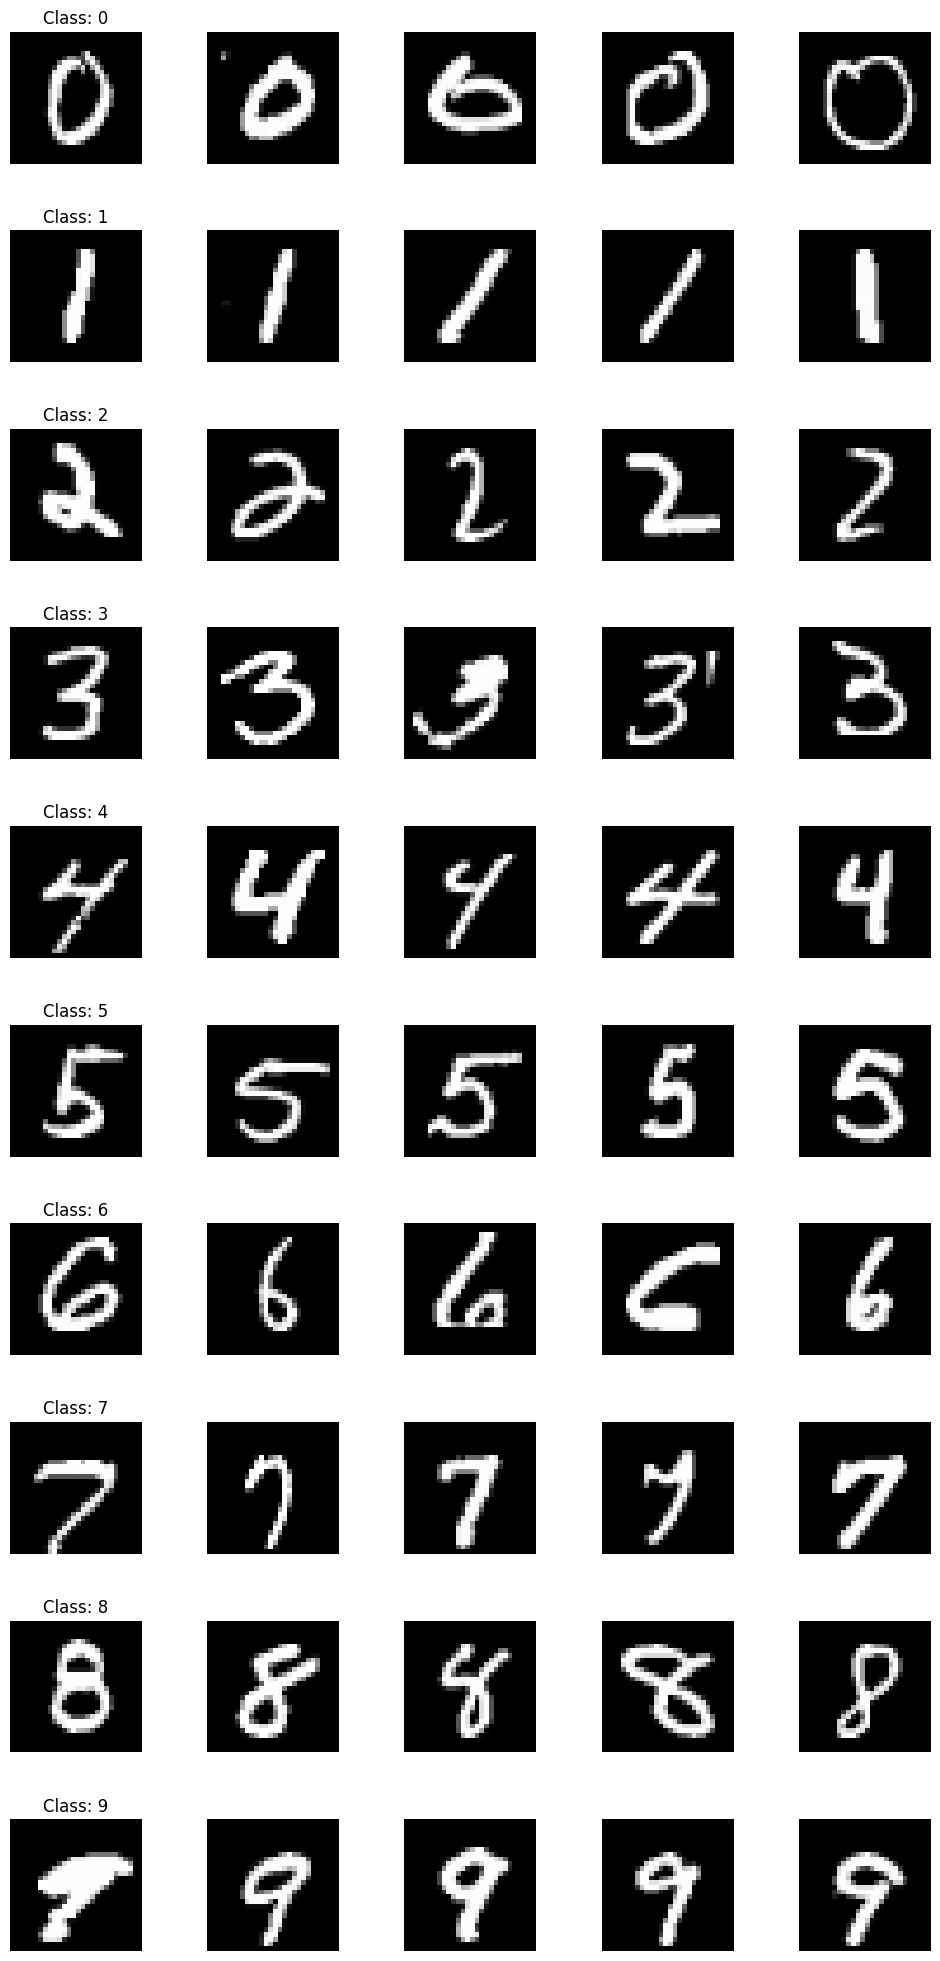

In [123]:
fig, axs = plt.subplots(10, num_examples_per_class, figsize=(num_examples_per_class * 2, 20))
fig.tight_layout(pad=1.0)

for i, images in examples_per_class.items():
    for j, img in enumerate(images):
        ax = axs[i, j]
        ax.imshow(img, cmap='gray', interpolation='none')
        if j == 0:
            ax.set_title(f"Class: {i}")
        ax.axis('off')

plt.show()

### Task-2:
<li> Write a 3-Layer MLP using PyTorch all using Linear layers. Print the number of trainable parameters of the model. [4 pts]

In [124]:
class NN(nn.Module):
    def __init__(self, input_size, num_classes):  # 784 (nodes) input size (28*28 images)
        super(NN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#### Testing the i/o tensor shape

In [125]:
model = NN(784, 10)
x = torch.randn(64, 784)
print(model(x).shape)

torch.Size([64, 10])


#### Parameters

In [126]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [127]:
print(count_parameters(model))

52650


### Task-3:
<li> Train the model for 5 epochs using Adam as the optimizer and
CrossEntropyLoss as the Loss Function.
<li> Make sure to evaluate the model on the validation set after each epoch and save the best model as well as log the accuracy and loss of the model on training and validation data at the
end of each epoch. [4 pts]

#### Training Device

In [128]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [129]:
print(device)

cuda


In [130]:
model = NN(input_size=input_size, num_classes=num_classes).to(device)

In [131]:
print(count_parameters(model))

52650


In [132]:
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 64]          50,240
            Linear-3                   [-1, 32]           2,080
            Linear-4                   [-1, 10]             330
Total params: 52,650
Trainable params: 52,650
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.20
Estimated Total Size (MB): 0.21
----------------------------------------------------------------


#### Optimizer and Loss Function

In [133]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params = model.parameters(), lr = learning_rate)

### Training Loop

In [134]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

    model.train()
    return num_correct / num_samples

#### Helper function for the training loop

In [135]:
# training loop metrics

train_losses = []
train_accuracies = []

In [136]:
def train(epoch):
    train_loss = 0
    loop = tqdm(enumerate(train_loader), total=len(train_loader))
    for batch_idx, (data, targets) in loop:
        # get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward
        scores = model(data)
        loss = criterion(scores, targets)

        # backward
        optimizer.zero_grad()  # so it doesn't store gradients from previous backprops
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

        # accumulating loss over an epoch
        train_loss += loss.item()

        loop.set_description(f"Epoch [{epoch}/{num_epochs}]")
        loop.set_postfix(loss=loss.item(), acc=torch.rand(1).item())

    train_loss = train_loss / len(train_loader)

    # storing the train losses over an epoch in a list
    train_losses.append(train_loss)

    train_accuracy = check_accuracy(train_loader, model)
    train_accuracies.append(train_accuracy)

    return train_loss, train_accuracy

#### Helper function for Validation Loop

In [137]:
val_losses = []
val_accuracies = []

In [138]:
def val(epoch):

   val_loss=0

   with torch.no_grad():
     for batch_idx, (data, targets) in enumerate(val_loader): # dividing into batches is possibly unecessary (will check later)

        # get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # calling the model with the val data and calculating the loss
        scores = model(data)

        loss = criterion(scores, targets)
        val_loss += loss.item()              # accumulating val loss over an epoch

   val_accuracy = check_accuracy(val_loader, model)
   val_accuracies.append(val_accuracy)

   val_loss = val_loss/len(test_loader)
   val_losses.append(val_loss)  # storing the validation losses over epochs in a list

   return val_loss, val_accuracy

In [139]:
def save_model(model, filename):
    torch.save(model.state_dict(), filename)
    print(f"Model saved successfully to {filename}")

#### Loop

In [140]:
for epoch in range(num_epochs):
    model.train()
    loss_train, acc_train = train(epoch)
    model.eval()
    loss_valid, acc_valid = val(epoch)
    print('Epoch: {}  Train Loss: {:.4f}  Train Accuracy: {:.4f}  Validation Loss: {:.4f}  Validation Accuracy: {:.4f}'.format(epoch+1, loss_train, acc_train, loss_valid, acc_valid))

    # best model based on val accuracy
    prev_max = 0
    if acc_valid > prev_max:
      save_model(model, "best_val")
    prev_max = max(acc_valid, prev_max)

Epoch [0/5]: 100%|██████████| 750/750 [00:11<00:00, 66.22it/s, acc=0.56, loss=0.221]   


Epoch: 1  Train Loss: 0.4574  Train Accuracy: 0.9338  Validation Loss: 0.2880  Validation Accuracy: 0.9318
Model saved successfully to best_val


Epoch [1/5]: 100%|██████████| 750/750 [00:10<00:00, 69.29it/s, acc=0.656, loss=0.241]   


Epoch: 2  Train Loss: 0.2070  Train Accuracy: 0.9500  Validation Loss: 0.2317  Validation Accuracy: 0.9435
Model saved successfully to best_val


Epoch [2/5]: 100%|██████████| 750/750 [00:10<00:00, 72.28it/s, acc=0.792, loss=0.168]    


Epoch: 3  Train Loss: 0.1598  Train Accuracy: 0.9580  Validation Loss: 0.2059  Validation Accuracy: 0.9489
Model saved successfully to best_val


Epoch [3/5]: 100%|██████████| 750/750 [00:10<00:00, 70.13it/s, acc=0.0112, loss=0.0395] 


Epoch: 4  Train Loss: 0.1305  Train Accuracy: 0.9680  Validation Loss: 0.1699  Validation Accuracy: 0.9572
Model saved successfully to best_val


Epoch [4/5]: 100%|██████████| 750/750 [00:11<00:00, 64.78it/s, acc=0.0416, loss=0.0716] 


Epoch: 5  Train Loss: 0.1072  Train Accuracy: 0.9741  Validation Loss: 0.1541  Validation Accuracy: 0.9616
Model saved successfully to best_val


### Performance of the Final Model on the Test Data.

#### Helper function to test the model on test loader

In [141]:
def test():

   test_loss=0

   with torch.no_grad():
     for batch_idx, (data, targets) in enumerate(test_loader): # dividing into batches is possibly unecessary (will check later)

        # get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # calling the model with the val data and calculating the loss
        scores = model(data)

        loss = criterion(scores, targets)
        test_loss += loss.item()              # accumulating val loss over an epoch

   test_accuracy = check_accuracy(test_loader, model)
   test_loss = test_loss/len(test_loader)

   return test_loss, test_accuracy

In [142]:
test_loss, test_accuracy = test()

In [143]:
print(f"Test Loss : {test_loss}, Test Accuracy : {test_accuracy}")

Test Loss : 0.12272320013896675, Test Accuracy : 0.9613999724388123


### Task-4:
<li> Visualize correct and Incorrect predictions along with
Loss-Epoch and Accuracy-Epoch graphs for both training and validation. [3 pts]

#### Visualize Predictions

In [144]:
def gather_predictions(model, device, data_loader):
    model.eval()
    correct_predictions = []
    incorrect_predictions = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            for img, label, pred in zip(images, labels, predicted):
                if pred == label and len(correct_predictions) < 4:
                    correct_predictions.append((img, label))
                elif pred != label:
                    incorrect_predictions.append((img, label, pred))

                if len(correct_predictions) >= 4:
                    break
            if len(correct_predictions) >= 4:
                break

    return correct_predictions, incorrect_predictions

In [145]:
def plot_correct_predictions(correct_predictions):
    plt.figure(figsize=(10, 2.5))
    for idx, (img, label) in enumerate(correct_predictions):
        plt.subplot(1, 4, idx + 1)
        plt.imshow(img.cpu().numpy().squeeze(), cmap='gray')
        plt.title(f'True: {label}')
        plt.axis('off')
    plt.suptitle('Correct Predictions')
    plt.subplots_adjust(hspace=1.0)
    plt.show()

In [160]:
def plot_incorrect_predictions(loader, model):
    incorrect_samples = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.cuda() if torch.cuda.is_available() else inputs
            labels = labels.cuda() if torch.cuda.is_available() else labels
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            incorrect_mask = predicted != labels
            incorrect_indices = torch.nonzero(incorrect_mask).squeeze(dim=1)  # Ensure 1-dimensional tensor
            if incorrect_indices.numel() > 0:  # Check if there are any incorrect indices
                for idx in incorrect_indices:
                    incorrect_samples.append((inputs[idx].cpu(), labels[idx].cpu(), predicted[idx].cpu()))  # Move tensors to CPU
    
    # print(incorrect_samples.shape)
    incorrect_samples = incorrect_samples[:20]
         
    if not incorrect_samples:  # If no incorrect samples found, print a message and return
        print("No incorrect predictions found.")
        return
    
    num_samples = len(incorrect_samples)
    num_rows = int(np.ceil(num_samples / 4))
    fig, axs = plt.subplots(num_rows, 4, figsize=(16, 4*num_rows))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    
    for i, (sample, true_label, pred_label) in enumerate(incorrect_samples):
        row = i // 4
        col = i % 4
        ax = axs[row, col]
        ax.imshow(sample.permute(1, 2, 0).numpy())  # Convert to NumPy array after moving to CPU
        ax.axis('off')
        ax.set_title(f'True: {true_label}, Predicted: {pred_label}')
    
    for i in range(num_samples, num_rows*4):
        row = i // 4
        col = i % 4
        axs[row, col].axis('off')
        
    plt.show()

### Correct and Incorrect Predictions

In [147]:
print(test_loader)
print(dir(test_loader))

['_DataLoader__initialized', '_DataLoader__multiprocessing_context', '_IterableDataset_len_called', '__annotations__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_auto_collation', '_dataset_kind', '_get_iterator', '_index_sampler', '_is_protocol', '_iterator', 'batch_sampler', 'batch_size', 'check_worker_number_rationality', 'collate_fn', 'dataset', 'drop_last', 'generator', 'multiprocessing_context', 'num_workers', 'persistent_workers', 'pin_memory', 'pin_memory_device', 'prefetch_factor', 'sampler', 'timeout', 'worker_init_fn']


In [148]:
correct_predictions, incorrect_predictions = gather_predictions(model, device, test_loader)

In [149]:
print(correct_predictions)

[(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.000

In [150]:
print(incorrect_predictions)

[]


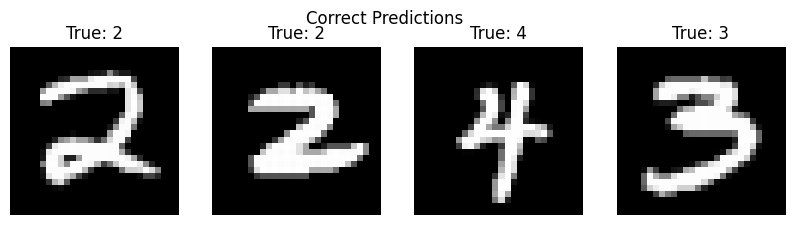

In [151]:
plot_correct_predictions(correct_predictions)

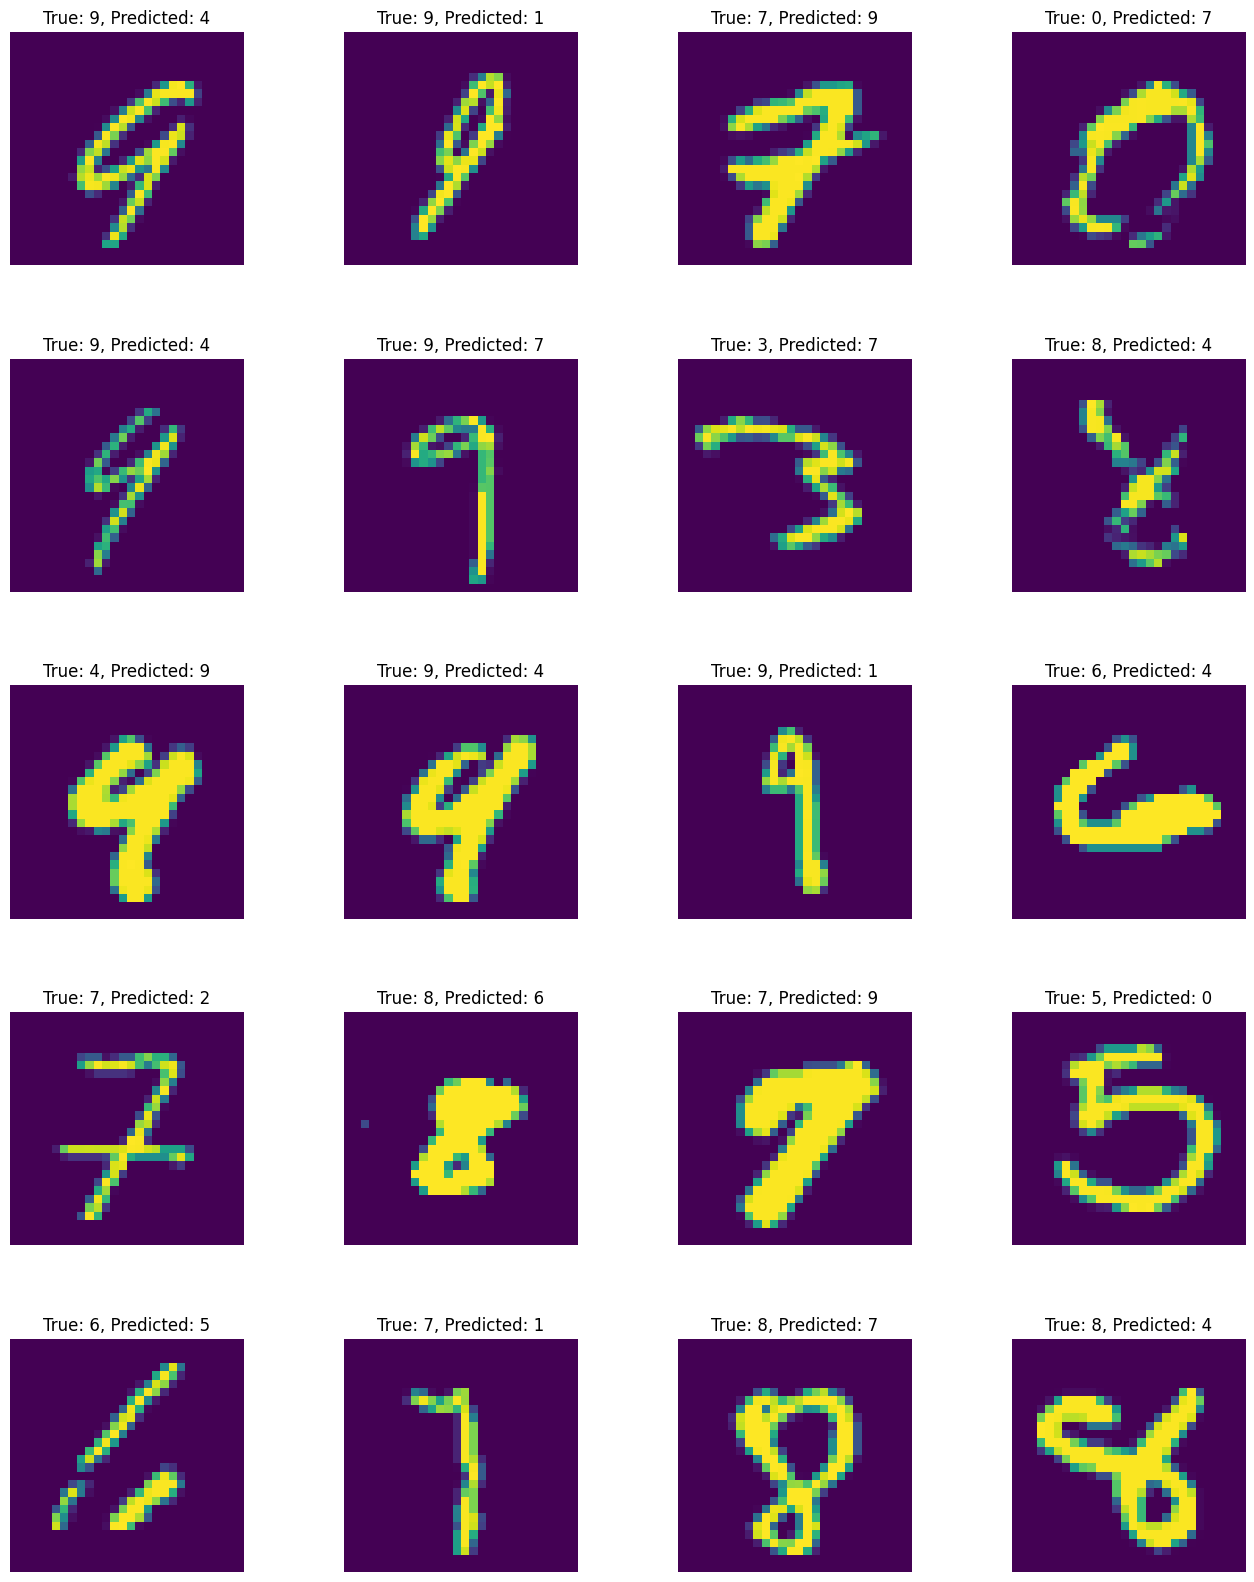

In [161]:
plot_incorrect_predictions(test_loader, model)

### Accuracy and Loss Plots

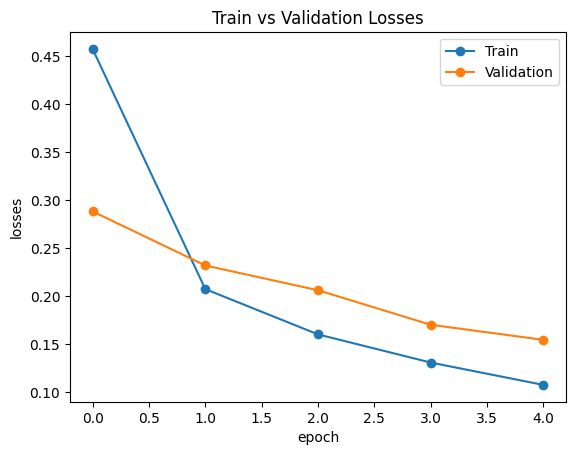

In [155]:
from matplotlib import pyplot as plt

plt.plot(train_losses,'-o')
plt.plot(val_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Validation'])
plt.title('Train vs Validation Losses')

plt.show()

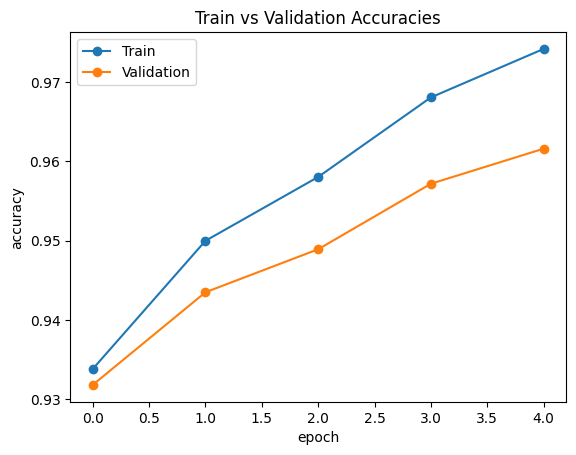

In [159]:
train_accuracies = [acc.cpu().numpy() if torch.is_tensor(acc) and acc.device.type == 'cuda' else acc for acc in train_accuracies]
val_accuracies = [acc.cpu().numpy() if torch.is_tensor(acc) and acc.device.type == 'cuda' else acc for acc in val_accuracies]

plt.plot(train_accuracies, '-o')
plt.plot(val_accuracies, '-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train', 'Validation'])
plt.title('Train vs Validation Accuracies')
plt.show()



---

